# 【課題】量子相関を調べる

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\bra}[1]{\langle#1|}$
$\newcommand{\rmI}{\mathrm{I}}$
$\newcommand{\rmII}{\mathrm{II}}$
$\newcommand{\rmIII}{\mathrm{III}}$
$\newcommand{\rmIV}{\mathrm{IV}}$

第一回の実習ではCHSH不等式の破れを調べるために、2つの量子ビットの相関関数$C^{i} \, (i=\rmI, \rmII, \rmIII, \rmIV)$という量を量子コンピュータを使って計算しました。この課題では、この量をもう少し細かく調べてみましょう。

```{contents} 目次
---
local: true
---
```

## QCシミュレータの使い方

実習で見たように、QCで実現される量子状態は、量子力学の公理に基づいて理論的に計算・予測できます。そこで用いられる数学的操作も単なる足し算や掛け算（線形演算）なので、実はQCの量子状態は（古典）計算機で比較的簡単に計算できます。当然のことですが、QCは何も魔法のブラックボックスというわけではありません。

ただし、古典計算機で量子状態を再現するためには、特殊な場合を除いて、量子ビット数の指数関数的な量のメモリが必要になります。これも前半で見たように、$n$量子ビットあれば、系の自由度（degrees of freedom / dof: 実数自由パラメータの数）は$2^{n+1} - 2$ですので、例えば各自由度を64ビット（＝8バイト）の浮動小数点で表現するとしたら、必要なメモリは(-2を無視して)

$$
2^3\, \mathrm{(bytes / dof)} \times 2^{n+1}\, \mathrm{(dof)} = 2^{n+4}\, \mathrm{(bytes)}
$$

なので、$n=16$で1 MiB、$n=26$で1 GiB、$n=36$で1 TiBです。現在の計算機では、ハイエンドワークステーションでRAMが$\mathcal{O}(1)$ TiB、スパコン「富岳」で5 PB (~2<sup>52</sup> bytes)なのに対し、QCではすでに$n=127$のものが存在するので、既に古典計算機でまともにシミュレートできない機械が存在していることになります。

しかし、逆に言うと、$n \sim 30$程度までの回路であれば、ある程度のスペックを持った計算機で厳密にシミュレートできるということが言えます。じっさい世の中には[数多くの](https://quantiki.org/wiki/list-qc-simulators)シミュレータが存在します。Qiskitにも様々な高機能シミュレータが同梱されています。

シミュレーションはローカル（手元のPythonを動かしているコンピュータ）で実行できるので、ジョブを投げて結果を待つ時間が省けます。この課題ではたくさんの細かい量子計算をするので、実機を使わず、`qasm_simulator`というQiskitに含まれるシミュレータを利用します。

Qiskitのシミュレータには`Aer`というオブジェクトからアクセスします。`Aer`は実習で登場した`IBMQ`と同様の構造をしており、複数のシミュレータをバックエンドとして管理しています。そのうちの`qasm_simulator`を取り出します。

In [1]:
# まずは全てインポート
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram

print('notebook ready')

notebook ready


In [2]:
# シミュレータをバックエンドとして使うときは、IBMQのプロバイダではなくAerのget_backend()を呼ぶ
simulator = Aer.get_backend('qasm_simulator')
print(simulator.name())

qasm_simulator


実習の内容を再現してみましょう。

In [3]:
circuits = []

circuit = QuantumCircuit(2, name='circuit_I')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.measure_all()
circuits.append(circuit)

circuit = QuantumCircuit(2, name='circuit_II')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.measure_all()
circuits.append(circuit)

circuit = QuantumCircuit(2, name='circuit_III')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
circuits.append(circuit)

circuit = QuantumCircuit(2, name='circuit_IV')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
circuits.append(circuit)

S = 2.8138


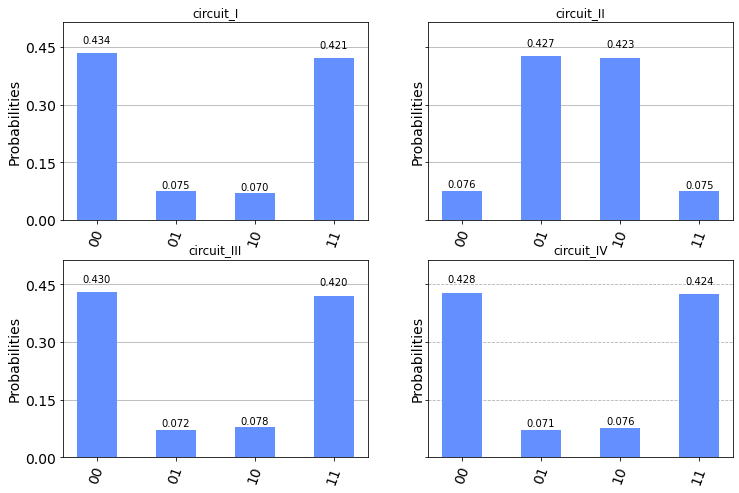

In [4]:
# シミュレータにはショット数の制限がないので、時間の許す限りいくらでも大きい値を使っていい
shots = 10000

# 実習と同じく transpile() - 今は「おまじない」と思ってよい
circuits = transpile(circuits, backend=simulator)
# シミュレータもバックエンドと同じように振る舞うので、runメソッドで回路とショット数を受け取り、ジョブオブジェクトを返す
sim_job = simulator.run(circuits, shots=shots)

# シミュレータから渡されたジョブオブジェクトは実機のジョブと全く同じように扱える
sim_result = sim_job.result()

C = np.zeros(4, dtype=float)
fig, axs = plt.subplots(2, 2, sharey=True, figsize=[12., 8.])
for idx, (circuit, ax) in enumerate(zip(circuits, axs.reshape(-1))):
    counts = sim_result.get_counts(idx)
    plot_histogram(counts, ax=ax)
    ax.set_title(circuit.name)
    ax.yaxis.grid(True)
    
    C[idx] = counts.get('00', 0) + counts.get('11', 0) - counts.get('01', 0) - counts.get('10', 0)
    
C /= shots
    
S = C[0] - C[1] + C[2] + C[3]
print('S =', S)

上のように、`qasm_simulator`は実機と同様に`run`関数を実行でき、ヒストグラムデータを返します。実機ではショット数に制限がありますが、シミュレータにはありません。ただしショット数が多いほど、当然実行に時間がかかります。といってもこの程度の回路であれば常識的なショット数ならほぼ瞬間的にジョブの実行が終わるので、上の例では実習で使った`job_monitor()`関数を使用していません。また、シミュレータにはノイズがない[^simulator_noise]ので、$S$の計算結果が統計誤差の範囲内で理論値と一致していることが見て取れます。

[^simulator_noise]: 標準設定において。実機の振る舞いに従うよう、あえてノイズを加えるような設定も存在します。

## 測定基底の変換

さて、おさらいをすると、上の$C^{\rmI, \rmII, \rmIII, \rmIV}$を計算する4つの回路は以下のようなものでした。

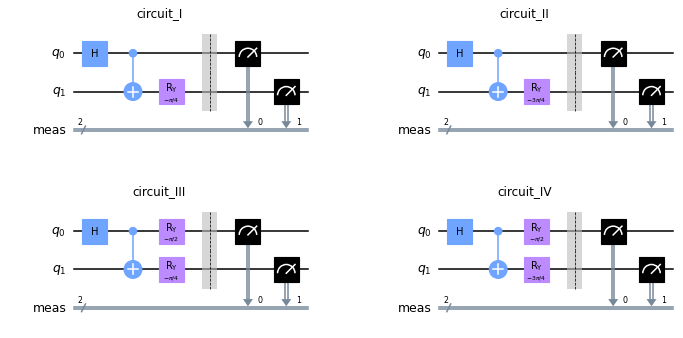

In [5]:
fig, axs = plt.subplots(2, 2, figsize=[12., 6.])
for circuit, ax in zip(circuits, axs.reshape(-1)):
    circuit.draw('mpl', ax=ax)
    ax.set_title(circuit.name)

ベル状態を作るところまではすべての回路で共通で、その後それぞれ異なる角度の$R_y$ゲートをかけています。実習では深く立ち入りませんでしたが、この$R_y$ゲートはベル状態を$\{\ket{0}, \ket{1}\}$とは異なる基底で測定するために置かれています。どういうことか、以下で説明します。

ここまで「測定」とはレジスタの量子状態$\sum_{j=0}^{2^n-1} c_j \ket{j}$からビット列$j$を確率$|c_j|^2$で得る行為である、と説明してきました。しかし、本来「測定」はもっと一般的な概念です。それを理解するために、まず、量子力学的には計算基底状態$\ket{j}$は何ら特別な状態ではないということを理解しておきましょう。

例えば1量子ビットにおいて、計算基底状態は$\ket{0}$と$\ket{1}$ですが、以下のような状態$\ket{\theta_{+}}$と$\ket{\theta_{-}}$を考えることもできます。

```{math}
:label: theta_ket_def
\ket{\theta_{+}} := R_y(\theta)\ket{0} = \cos\frac{\theta}{2}\ket{0} + \sin\frac{\theta}{2}\ket{1} \\
\ket{\theta_{-}} := R_y(\theta)\ket{1} = -\sin\frac{\theta}{2}\ket{0} + \cos\frac{\theta}{2}\ket{1}
```

すると、

```{math}
:label: theta_ket_inverse_def
\ket{0} = \cos\frac{\theta}{2}\ket{\theta_{+}} - \sin\frac{\theta}{2}\ket{\theta_{-}} \\
\ket{1} = \sin\frac{\theta}{2}\ket{\theta_{+}} + \cos\frac{\theta}{2}\ket{\theta_{-}},
```

つまり、計算基底状態が$\ket{\theta_{+}}$と$\ket{\theta_{-}}$の重ね合わせとして表現できます。量子ビットの任意の状態は$\ket{0}$と$\ket{1}$の重ね合わせで表現できるので、$\ket{\theta_{+}}$と$\ket{\theta_{-}}$の重ね合わせでも表現できるということになります。そのようなときは$\ket{\theta_{+}}$と$\ket{\theta_{-}}$を基底として状態を表しているわけです。

一般に、量子力学的には、2つの異なる状態$\ket{a} \nsim \ket{b}$を考えれば、それらの重ね合わせで量子ビットの任意の状態が表現できます。そして、$\ket{a}$と$\ket{b}$が直交する[^orthogonal]ときに状態$\ket{\psi}$が

$$
\ket{\psi} = \alpha \ket{a} + \beta \ket{b}
$$

と表現されるならば、「基底$\ket{a}$と$\ket{b}$についての測定」という操作を考えることができます。$\ket{\psi}$に対してそのような測定をすると、状態$\ket{a}$が確率$|\alpha|^2$で、状態$\ket{b}$が確率$|\beta|^2$で得られます。

量子計算においても、アルゴリズムの一部として、計算の結果実現した状態を特定の基底で測定するということが多々あります。ところが、ここで若干問題があります。量子コンピュータは実装上、計算基底でしか測定ができないのです。量子力学の理論的には特別でない$\ket{0}$と$\ket{1}$ですが、量子コンピュータという実態にとっては具体的な対応物があるのです。

そこで、量子計算では、状態を任意の基底で測定することを諦め、反対に状態を変化させてしまいます。例えば、本当は上の$\ket{\theta_{+}}$と$\ket{\theta_{-}}$という基底で量子ビットの状態$\ket{\psi} = \alpha \ket{\theta_{+}} + \beta \ket{\theta_{-}}$を測定したいとします。しかし計算基底でしか測定ができないので、代わりに$R_y(-\theta)$を$\ket{\psi}$にかけます。すると式{eq}`theta_ket_def`から

$$
R_y(-\theta)\ket{\theta_{+}} = \ket{0} \\
R_y(-\theta)\ket{\theta_{-}} = \ket{1}
$$

なので、

$$
R_y(-\theta)\ket{\psi} = \alpha \ket{0} + \beta \ket{1}
$$

が得られます。この$R_y(-\theta)\ket{\psi}$を計算基底で測定した結果は、$\ket{\psi}$を$\ket{\theta_{+}}, \ket{\theta_{-}}$基底で測定した結果と等価です。

このように、測定を行いたい基底（ここでは$\ket{\theta_{+}}, \ket{\theta_{-}}$）を$\ket{0}, \ket{1}$から得るための変換ゲート（$R_y(\theta)$）の逆変換を測定したい状態にかけることで、計算基底での測定で求める結果を得ることができます。

## 観測量の期待値とその計算法

課題の説明に入る前に、さらに話が込み入ってきますが、量子計算でも多出する（ワークブックでは特に{doc}`vqe`以降）概念である「観測量の期待値」について説明します。

観測量とはそのまま「観測できる量」のことで、量子状態から取り出せる（古典的）情報のこととも言えます。例えば、何かしらの粒子の運動を量子力学的に記述した場合、その粒子の位置や運動量などが観測量です。

ケットで表される量子状態に対して、観測量はケットに作用する「エルミート演算子」で表現されます。エルミート以前にそもそも演算子という言葉をこれまで使っていませんが、量子力学において演算子とは、状態ケットを他の状態ケットに変換する作用で、特に線形なもの、すなわち

$$
A (\ket{\psi} + \ket{\phi}) = A \ket{\psi} + A \ket{\phi}
$$

が成り立つような$A$のことを指します。例えば実習で紹介したいろいろな量子ゲートはすべて演算子[^unitary]です。

さて、それではエルミート演算子はというと、（細かい定義は参考文献に譲りここで必要な最小限のことだけ述べると、）**対角化可能で、実数の固有値を持つ**という性質を持つ演算子のことです。つまり、$A$が$N$次元の量子状態の空間のエルミート演算子であれば、

$$
A \ket{\phi_j} = a_j \ket{\phi_j}
$$

が成り立つような状態$\ket{\phi_j}$と実数$a_j$の組が$N$個存在し、各$\ket{\phi_j} \, (j=0,\dots,N-1)$は互いに直交します。このように演算子を状態にかけた結果がもとの状態の定数倍になるというのは実は特別なことで、例えば実習で出てきたゲートのうち計算基底にそのように作用するのは$Z$や$R_z$ゲートだけです。このような関係が成り立つとき、状態ケット$\ket{\phi_j}$を演算子$A$の固有ベクトル、$a_j$を固有値と呼びます。そして、この固有値$a_j$が、演算子$A$で表される観測量の値に対応します[^continuous_observables]。

さて、$A$が$n$ビット量子レジスタに対する演算子であるとします。レジスタの状態$\ket{\psi}$が$A$の固有ベクトルで

$$
\ket{\psi} = \sum_{j=0}^{2^n-1} \gamma_j \ket{\phi_j}
$$

と分解されるとき、この状態を固有ベクトル基底$\{\ket{\phi_j}\}$で測定すると、状態$\ket{\phi_j}$が確率$|\gamma_j|^2$で得られます。そして、状態が$\ket{\phi_j}$であれば観測量$A$の値は$a_j$です。

そのような測定を多数回繰り返して$A$の値の期待値を求めることを考えます。期待値の定義は「確率変数のすべての値に確率の重みを付けた加重平均」です。$A$の状態$\ket{\psi}$における期待値を$\bra{\psi} A \ket{\psi}$と表すと、$A$が確率分布$\{|\gamma|^2_j\}$に従って値$\{a_j\}$を取るので、

$$
\bra{\psi} A \ket{\psi} = \sum_{j=0}^{2^n-1} a_j |\gamma_j|^2
$$

となります。ここから、量子コンピュータにおいて観測量の期待値を計算する方法を見出すことができます。具体的には、

1. 観測量をエルミート演算子で表現する
1. 演算子を対角化し、固有値と対応する固有ベクトルを求める
1. 固有ベクトルを基底として、レジスタの状態を測定する
1. 測定から得られた確率分布を重みとして固有値の平均値を取る

です[^pauli_decomposition]。3の測定の際には、上のセクションで説明した測定基底の変換を利用します。

## CHSH不等式の解釈

実習の中で、

$$
C = P_{00} - P_{01} - P_{10} + P_{11}
$$

という量を計算しました。ここで、$P_{lm}$は2つの量子ビットでそれぞれ$l, m \, (=0,1)$が得られる確率でした（コードで言えば`counts.get('lm') / shots`に対応）。実はこの量$C$は、2ビットレジスタにおけるある観測量の期待値として捉えることができます。

まず、1つの量子ビットに対して、固有値が$\pm 1$であるような観測量$\sigma^{\theta}$を考えます。そのような$\sigma^{\theta}$は無数に存在し、固有ベクトルで区別できます。$\theta$は固有ベクトルを決める何らかのパラメータです[^specifying_eigenvectors]。例えば$\sigma^0$という観測量を、計算基底を固有ベクトルとして、

$$
\sigma^0 \ket{0} = \ket{0} \\
\sigma^0 \ket{1} = -\ket{1}
$$

で定義できる、という具合です。

次に、2つの量子ビットA, Bからなるレジスタを考え、$\sigma^{\kappa}$をAの、$\sigma^{\lambda}$をBの観測量とします。また、それぞれの演算子の固有ベクトルを

$$
\sigma^{\kappa} \ket{\kappa_{\pm}} = \pm \ket{\kappa_{\pm}} \\
\sigma^{\lambda} \ket{\lambda_{\pm}} = \pm \ket{\lambda_{\pm}}
$$

で定義します。これらの固有ベクトルを使って、レジスタの状態$\ket{\psi}$を

$$
\ket{\psi} = c_{++} \ket{\lambda_+}_B \ket{\kappa_+}_A + c_{+-} \ket{\lambda_+}_B \ket{\kappa_-}_A + c_{-+} \ket{\lambda_-}_B \ket{\kappa_+}_A + c_{--} \ket{\lambda_-}_B \ket{\kappa_-}_A
$$

と分解します。ケットはAが右、Bが左になるよう並べました。すると、積$\sigma^{\lambda}_B \sigma^{\kappa}_A$の$\ket{\psi}$に関する期待値は、

$$
\bra{\psi} \sigma^{\lambda}_B \sigma^{\kappa}_A \ket{\psi} = |c_{++}|^2 - |c_{+-}|^2 - |c_{-+}|^2 + |c_{--}|^2
$$

です。

最後に、同じ結果を計算基底での測定で表すために、$\ket{\psi}$に対して基底変換を施します。$\{\ket{\kappa_{\pm}}, \ket{\lambda_{\pm}}\}$が何らかのパラメータ付きゲート$R(\theta)$を通して計算基底と

$$
\ket{\kappa_+} = R(\kappa) \ket{0} \\
\ket{\kappa_-} = R(\kappa) \ket{1} \\
\ket{\lambda_+} = R(\lambda) \ket{0} \\
\ket{\lambda_-} = R(\lambda) \ket{1}
$$

で結びついているなら、状態$\ket{\psi'} = R^{-1}_B(\lambda) R^{-1}_A(\kappa) \ket{\psi}$を計算基底で測定したとき、

$$
P_{00} = |c_{++}|^2 \\
P_{01} = |c_{+-}|^2 \\
P_{10} = |c_{-+}|^2 \\
P_{11} = |c_{--}|^2
$$

が成り立ちます。確認のためはっきりさせておくと、左辺は$\ket{\psi'}$を計算基底で測定し、ビット列00, 01, 10, 11を得る確率です。つまり、最初の$C$は

$$
C = \bra{\psi'} \sigma^0_B \sigma^0_A \ket{\psi'} = \bra{\psi} \sigma^{\lambda}_B \sigma^{\kappa}_A \ket{\psi}
$$

を表していたのでした。

これを踏まえて、CHSH不等式の左辺は結局何を計算していたのか、見直してみましょう。ベル状態を

```{math}
:label: bell_state
\ket{\Psi} := \frac{1}{\sqrt{2}} \left(\ket{0}_B \ket{0}_A + \ket{1}_B \ket{1}_A\right)
```

とおきます。$R_y(\pi/4)\ket{0}, R_y(\pi/2)\ket{0}, R_y(3\pi/4)\ket{0}$が固有値$+1$の固有ベクトルとなるような演算子をそれぞれ$\sigma^{\pi/4}, \sigma^{\pi/2}, \sigma^{3\pi/4}$とすると、

$$
S = C^{\rmI} - C^{\rmII} + C^{\rmIII} + C^{\rmIV} = \bra{\Psi} \sigma^{\pi/4}_B \sigma^0_A \ket{\Psi} - \bra{\Psi} \sigma^{3\pi/4}_B \sigma^0_A \ket{\Psi} + \bra{\Psi} \sigma^{\pi/4}_B \sigma^{\pi/2}_A \ket{\Psi} + \bra{\Psi} \sigma^{3\pi/4}_B \sigma^{\pi/2}_A \ket{\Psi}
$$

がわかります。

観測量$\sigma^{\theta}$を用いてCHSH不等式をより正確に表現すると、

> 4つのパラメータ$\kappa, \lambda, \mu, \nu$を用いて  
> $S(\kappa, \lambda, \mu, \nu) = \langle \sigma^{\lambda}\sigma^{\kappa} \rangle - \langle \sigma^{\nu}\sigma^{\kappa} \rangle + \langle \sigma^{\lambda}\sigma^{\mu} \rangle + \langle \sigma^{\nu}\sigma^{\mu} \rangle$
> という量を定義すると、エンタングルメントのない古典力学において$|S| \leq 2$である。

となります。

[^orthogonal]: ここまで状態ケットの内積に関する説明をしていませんが、線形代数に慣れている方は「量子力学の状態ケットはヒルベルト空間の要素である」と理解してください。慣れていない方は、量子ビットの直行する状態とは$\ket{0}$と$\ket{1}$に同じゲートをかけて得られる状態のことを言うと覚えておいてください。
[^unitary]: 量子ゲートは特にすべてユニタリ演算子と呼ばれるクラスの演算子です。
[^continuous_observables]: 上で粒子の位置や運動量という例を挙げたので、$a_j \, (j=0,\dots,N-1)$と離散的な固有値が観測量の値だというと混乱するかもしれません。位置や運動量といった連続的な値を持つ観測量は、無数に固有値を持つエルミート演算子で表されます。そのような演算子のかかる状態空間は無限次元です。
[^pauli_decomposition]: ただし、{doc}`dynamics_simulation`で議論するように、実際には量子ビット数が大きくなると演算子の対角化自体が困難になるので、まず観測量の演算子を「パウリ積」の和に分解し、個々のパウリ積の固有ベクトルを基底とした測定をします。
[^specifying_eigenvectors]: 量子ビットの一般の状態は実パラメータ2つで決まるので、$\sigma^{\theta, \phi}$などと書いたほうがより明示的ですが、ここでの議論では結局1パラメータしか使わないので、「何か一般の（次元を指定しない）パラメータ」として$\theta$と置いています。

## 問題：ベル状態について調べる

### 一般の$\sigma$演算子の期待値

上のように$R_y(\theta)\ket{0}$が固有値$+1$の固有ベクトルとなるような演算子を$\sigma^{\theta}$として、$\bra{\Psi} \sigma^{\chi}_B \sigma^{\theta}_A \ket{\Psi}$を計算してみましょう。まず基底変換を具体的に書き下します。

$$
\begin{align}
\ket{\Psi'} = & R_{y,B}(-\chi) R_{y,A}(-\theta) \frac{1}{\sqrt{2}} \left( \ket{00} + \ket{11} \right) \\
= & \frac{1}{\sqrt{2}} \left\{ \left[ \cos\left(\frac{\chi}{2}\right)\ket{0} - \sin\left(\frac{\chi}{2}\right)\ket{1} \right] \left[ \cos\left(\frac{\theta}{2}\right)\ket{0} - \sin\left(\frac{\theta}{2}\right)\ket{1} \right] \right. \\
& \left. + \left[ \sin\left(\frac{\chi}{2}\right)\ket{0} + \cos\left(\frac{\chi}{2}\right)\ket{1} \right] \left[ \sin\left(\frac{\theta}{2}\right)\ket{0} + \cos\left(\frac{\theta}{2}\right)\ket{1} \right] \right\} \\
= & \frac{1}{\sqrt{2}} \left[ \cos\left(\frac{\theta - \chi}{2}\right)\ket{00} - \sin\left(\frac{\theta - \chi}{2}\right)\ket{01} + \sin\left(\frac{\theta - \chi}{2}\right)\ket{10} + \cos\left(\frac{\theta - \chi}{2}\right)\ket{11} \right].
\end{align}
$$

したがって、

```{math}
:label: quantum_correlation
\begin{align}
\bra{\Psi} \sigma^{\chi}_B \sigma^{\theta}_A \ket{\Psi} & = \bra{\Psi'} \sigma^{0}_B \sigma^{0}_A \ket{\Psi'} \\
& = \cos^2\left(\frac{\theta - \chi}{2}\right) - \sin^2\left(\frac{\theta - \chi}{2}\right) \\
& = \cos(\theta - \chi)
\end{align}
```

となります。

### 実験1

上の計算結果を量子回路でも確認してみましょう。実習のように2ビット量子レジスタをベル状態にし、2つの量子ビットにそれぞれ適当な$R_y$ゲートをかけ、期待値$C$を$R_y$ゲートのパラメータの組み合わせについて二次元プロットに起こしてみます。

In [6]:
# Consider 20 points each for theta and phi (400 points total)
ntheta = 20
nchi = 20

thetas = np.linspace(0., np.pi, ntheta)
chis = np.linspace(0., np.pi, nchi)

# Construct a circuit for each (theta, chi) pair
circuits = []
# np.ndindex returns an iterator over a multi-dimensional array
# -> idx = (0, 0), (0, 1), ..., (1, 0), (1, 1), ...
for idx in np.ndindex(ntheta, nchi):
    theta = thetas[idx[0]]
    chi = chis[idx[1]]
    
    circuit = QuantumCircuit(2, name=f'circuit_{idx[0]}_{idx[1]}')
    
    # Create a circuit that forms a Bell state and then measures the two qubits
    # along theta and chi bases

    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit.measure_all()

    circuits.append(circuit)

# Execute all circuits in qasm_simulator and retrieve the results
simulator = Aer.get_backend('qasm_simulator')
shots = 10000
circuits = transpile(circuits, backend=simulator)
sim_job = simulator.run(circuits, shots=shots)
result = sim_job.result()

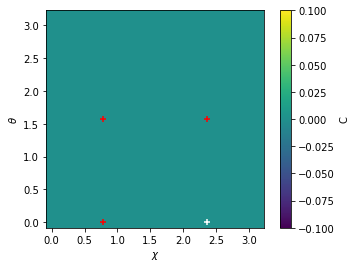

In [7]:
# Compute the C values for each (theta, chi)
c_values = np.zeros((ntheta, nchi), dtype=float)
for icirc, idx in enumerate(np.ndindex(ntheta, nchi)):
    # This is the counts dict for the (theta, chi) pair
    counts = result.get_counts(icirc)

    ##################
    ### EDIT BELOW ###
    ##################

    #c_values[idx] = ?

    ##################
    ### EDIT ABOVE ###
    ##################

# Making a 2D plot using imshow()
# The theta dimension of c_values must be reversed because imshow() puts the origin at the top left corner
dtheta = (thetas[1] - thetas[0]) * 0.5
dchi = (chis[1] - chis[0]) * 0.5
plt.imshow(c_values[::-1], extent=(chis[0] - dchi, chis[-1] + dchi, thetas[0] - dtheta, thetas[-1] + dtheta))
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\theta$')
plt.colorbar(label='C')
# Place markers at theta and chi values that realize |S| = 2 sqrt(2)
plt.scatter([np.pi / 4., np.pi / 4., 3. * np.pi / 4.], [0., np.pi / 2., np.pi / 2.], c='red', marker='+')
plt.scatter([3. * np.pi / 4.], [0.], c='white', marker='+');

プロット上に、合わせて$|S| = 2\sqrt{2}$となる時の$\theta, \chi$の値の組み合わせを表示してあります（$\langle \sigma^{\chi} \sigma^{\theta} \rangle$を足す点は赤、引く点は白）

### ベル状態の何がすごいのか？

ここまで、かなり天下り的に「エンタングルメント」や「ベル状態」が登場してきて、CHSH不等式が破れているから量子力学だ、と言われても、そもそも量子現象がないとしたら何が期待されるのか、なぜベル状態が不思議なのか、といったある種の「出発点」が欠けていると感じている方も多いかと思います（量子ネイティブを育成するという観点からは、出発点が量子力学でありエンタングルメントは当たり前、ということでいいのかもしれませんが）。量子現象のない「古典力学」とはすなわち、ボールを投げたら放物線を描いて地面に落ちる、といった我々の日常的な感覚に沿った物理法則体系とも言えます。そこで、一旦量子力学を忘れて、日常的な感覚でベル状態を解釈することを試みましょう。

**量子ビットAとBはそれぞれどんな状態にある？**

量子コンピュータ上で実験をしているので、量子ビットAとBは1mmも離れていません（IBMQのような超電導型のコンピュータの実態は、数mm四方のシリコンチップ上にプリントされた金属の回路です）が、これまでの議論にそもそもAとBの間の距離は一切登場しませんでした。実際、AとBをエンタングルさせてから、何らかの方法で二つを100m引き離したとしても、AとBの関係は全く変わりません。そのようにバラバラにして扱える二つの物があるとしたら、日常的な感覚で言えば、それぞれの物が独立に何らかの状態にあると思うのが自然です。ケットの記法で言えば、$\ket{\psi}_B\ket{\phi}_A$というような状態（「可分状態」）です。

ところが、式{eq}`bell_state`を見るとわかるように、量子ビットAもBも、$\ket{0}$や$\ket{1}$という状態にはありません。少し計算をしてみると、AやBにどんな基底変換を施しても、ベル状態を可分状態にすることができないことがわかります。ベル状態にある二つの量子ビットは相関していて、別々の独立な状態になく、二つを合わせて一つの状態と理解しなければいけません。「それぞれどんな状態にあるか」という問いは見当外れだったということです。

**五分五分の確率で$\ket{00}$か$\ket{11}$という状態をとる？**

ベル状態を計算基底で測定すると、00か11というビット列が等しい確率で得られます。ならば、二つの量子ビットが相関しているとしても、全体が$\ket{00}$という状態にあったり$\ket{11}$という状態にあったりして、それがランダムに切り替わっていると思えばいいのでしょうか？

再び式{eq}`bell_state`を眺めると、この解釈も正しくないことがわかります。例えば式{eq}`theta_ket_inverse_def`を用いると

```{math}
:label: bell_state_basis_change
\begin{align}
\ket{\Psi} = & \frac{1}{\sqrt{2}} \left(\ket{0}_B \ket{0}_A + \ket{1}_B \ket{1}_A\right) \\
= & \frac{1}{\sqrt{2}} \left[
\left( \cos\frac{\theta}{2} \ket{\theta_+}_B - \sin\frac{\theta}{2} \ket{\theta_-}_B \right)
\left( \cos\frac{\theta}{2} \ket{\theta_+}_A - \sin\frac{\theta}{2} \ket{\theta_-}_A \right) \right. \\
& \left. + \left( \sin\frac{\theta}{2} \ket{\theta_+}_B + \cos\frac{\theta}{2} \ket{\theta_-}_B \right)
\left( \sin\frac{\theta}{2} \ket{\theta_+}_A + \cos\frac{\theta}{2} \ket{\theta_-}_A \right)
\right] \\
= & \frac{1}{\sqrt{2}} \left( \ket{\theta_+}_B \ket{\theta_+}_A + \ket{\theta_-}_B \ket{\theta_-}_A \right)
\end{align}
```

となり、今度は全体が$\ket{\theta_+ \theta_+}$という状態にあったり$\ket{\theta_- \theta_-}$という状態にあったりするかのようにも見えます。

**全ての$\ket{\theta_{\pm}\theta_{\pm}}$が一様にランダムに含まれる？**

式{eq}`bell_state_basis_change`によると、AとBをどんな基底で測定しても、基底が揃ってさえいれば、100%相関した測定結果が得られることになります。ならば、$\ket{00}$と$\ket{11}$だけでなく、あらゆる$\ket{\theta\theta}$が等しい確率で実現しているという解釈はどうでしょうか？（$\ket{\theta_-} = \ket{(\theta + \pi)_+}$であり、全ての角度$\theta$を考えるので、$\pm$の添字を省略しています。）

残念ながらそれも正しくありません。ポイントは、測定をする基底をベル状態の生成の後に決められる（回路で言えば$H$とCNOTの後に$R_{y}$ゲートを自由にかけられる）ということです。ベル状態が、生成されるごとに何か一つランダムに$\ket{\theta\theta}$を作るというのであれば、その状態を後から選んだ別の角度$\chi$を用いて測定してしまったら、完全な相関は得られません。どんな基底で測定しても完全な相関が得られるためには、それぞれの量子ビットの状態があらかじめ決まっていてはいけないのです。

結論として、ベル状態では、量子ビットAもBも特定の状態にはなく、Aを測定した時に初めてBの状態が決まる（もしくはその逆）、そしてAとBがどれだけ離れていてもそれが成り立つ、ということになります。こういう言い方をすると、あたかもAとBがテレパシーで繋がっているようで、これが例えばアインシュタインがエンタングルメントの概念を「spooky action at a distance」と称して嫌がった（量子力学の定式化に間違いがあると主張した）理由です。

実際にはテレパシーがあるわけではないのですが、量子力学には「部分系の状態」という概念そのものが成り立たないような状態が存在し、古典力学と本質的に異なることは確かなようです。ちなみに、AとBが可分状態にあるとすれば、CHSH不等式の左辺に登場する$\langle \sigma^{\lambda}\sigma^{\kappa} \rangle$などの期待値は全て$\langle \sigma^{\lambda} \rangle \langle \sigma^{\kappa} \rangle$とそれぞれの系での期待値の積で表せるはずなので、

$$
\begin{align}
| S(\kappa, \lambda, \mu, \nu) | & = \big| \langle \sigma^{\lambda} \rangle \langle \sigma^{\kappa} \rangle - \langle \sigma^{\nu} \rangle \langle \sigma^{\kappa} \rangle + \langle \sigma^{\lambda} \rangle \langle \sigma^{\mu} \rangle + \langle \sigma^{\nu} \rangle \langle \sigma^{\mu} \rangle \big| \\
& \leq | \langle \sigma^{\lambda} \rangle | | \langle \sigma^{\kappa} + \sigma^{\mu} \rangle | + | \langle \sigma^{\nu} \rangle | | \langle \sigma^{\kappa} - \sigma^{\mu} \rangle | \\
& \leq | \langle \sigma^{\kappa} + \sigma^{\mu} \rangle | + | \langle \sigma^{\kappa} - \sigma^{\mu} \rangle | \\
& \leq 2
\end{align}
$$

です。最後の不等式では、$-1 \leq x, y \leq 1$を満たす$x, y$について$|x+y| + |x-y| \leq 2$が常に成り立つことを利用しました。

様々な可分状態がランダムに登場するとしても、全ての状態の組み合わせについて上の不等式が成り立つので、全体の平均は常に2以下となります。これが、「古典力学では$|S| \leq 2$」という命題の意味です。

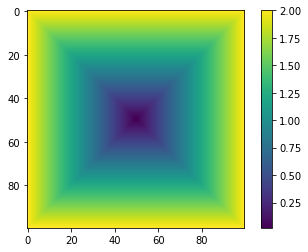

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1., 1., 100)[None, :]
y = np.linspace(-1., 1., 100)[:, None]
grid = np.abs(x + y) + np.abs(x - y)

plt.imshow(grid)
plt.colorbar();

### 実験2

上で言及した「確率1/2で$\ket{00}$、確率1/2で$\ket{11}$」という状態（「混合状態」という状態の一種です）も、少し工夫をすると量子回路で再現することができます。まず量子ビットを3つ使って「GHZ状態」

$$
\ket{\Phi} = \frac{1}{\sqrt{2}} \left( \ket{000} + \ket{111} \right)
$$

を作ります。右二つのケットに対応する量子ビットを今までと同様右からAとBと呼び、この状態を様々な基底で測定します。一番左のケットに対応する量子ビットCには何もせず、ただ測定をし、しかもその結果を無視します[^implicit_measurement]。

それでは、実験1のGHZバージョンを作ってみましょう。

[^implicit_measurement]: 実はただ量子ビットを放置するだけでも、測定をして結果を見ないのと同じ効果をもたらすことができます。これをthe principle of implicit measurementと呼びます。

In [9]:
# Construct a circuit for each (theta, chi) pair
circuits_ghz = []
# np.ndindex returns an iterator over a multi-dimensional array
# -> idx = (0, 0), (0, 1), ..., (1, 0), (1, 1), ...
for idx in np.ndindex(ntheta, nchi):
    theta = thetas[idx[0]]
    chi = chis[idx[1]]
    
    circuit = QuantumCircuit(3, name=f'circuit_{idx[0]}_{idx[1]}')
    
    # Create a circuit that forms a Bell state and then measures the two qubits
    # along theta and chi bases

    ##################
    ### EDIT BELOW ###
    ##################
    
    #circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit.measure_all()

    circuits_ghz.append(circuit)

# Execute all circuits in qasm_simulator and retrieve the results
circuits_ghz = transpile(circuits_ghz, backend=simulator)
sim_job_ghz = simulator.run(circuits_ghz, shots=shots)
result_ghz = sim_job_ghz.result()

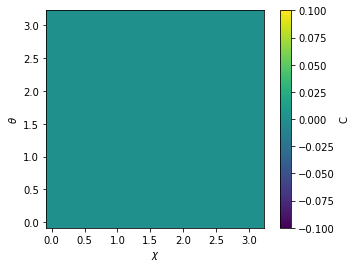

In [10]:
def counts_ignoring_qubit2(counts, bitstring):
    """Add the counts of cases where qubit C is 0 and 1"""
    
    return counts.get(f'0{bitstring}', 0) + counts.get(f'1{bitstring}', 0)

# Compute the C values for each (theta, chi)
c_values_ghz = np.zeros((ntheta, nchi), dtype=float)
for icirc, idx in enumerate(np.ndindex(ntheta, nchi)):
    # This is the counts dict for the (theta, chi) pair
    counts = result_ghz.get_counts(icirc)
    
    ##################
    ### EDIT BELOW ###
    ##################
    
    #c_values_ghz[idx] = ?

    ##################
    ### EDIT ABOVE ###
    ##################

# Making a 2D plot using imshow()
# The theta dimension of c_values must be reversed because imshow() puts the origin at the top left corner
plt.imshow(c_values_ghz[::-1], extent=(chis[0] - dchi, chis[-1] + dchi, thetas[0] - dtheta, thetas[-1] + dtheta))
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\theta$')
plt.colorbar(label='C');

ベル状態と明らかに違う挙動をしているのがわかります。原始的な方法ですが、計算した`c_values_ghz`から総当たりで$|S|$の最大値を計算してみましょう。

In [11]:
max_abs_s = 0.

# Use ndindex to iterate over all index combinations
for ikappa, ilambda, imu, inu in np.ndindex(ntheta, nchi, ntheta, nchi):
    abs_s = abs(c_values_ghz[ikappa, ilambda] - c_values_ghz[ikappa, inu] + c_values_ghz[imu, ilambda] + c_values_ghz[imu, inu])
    max_abs_s = max(abs_s, max_abs_s)
    
print(f'max |S| = {max_abs_s}')

max |S| = 0.0


量子ビットAとBに「古典的」な状態が実現しているようです。なぜでしょうか。（有限のショット数でシミュレーションをしているため、統計誤差によって$|S|$の値が微妙に2を超えてしまうかもしれません）

余談ですが、この実験は量子力学における測定という行為の一つのモデルとして考えることもできます。測定装置もその装置の出力を読み取る我々も究極的には量子力学的存在なので、測定とは対象系と測定装置の間にエンタングルメントを生じさせることに他なりません。そのエンタングルメントの結果、対象系（この実験では量子ビットAB）では量子力学的な重ね合わせ状態（ベル状態）が壊れ、混合状態が生じるというわけです。

**提出するもの**

- 完成した回路のコード（EDIT BELOW / EDIT ABOVEの間を埋める）とシミュレーション結果によるプロット
- 実験2で、「確率1/2で$\ket{00}$、確率1/2で$\ket{11}$」という状態が作られたメカニズムの考察
- おまけ（評価対象外）：実験2で、量子ビットCをどのような基底で測定しても、その結果を無視する限りにおいて$C$の値は変わらないということの証明
- おまけ（評価対象外）：実験2で、量子ビットCをある基底で測定し、その結果が0であった時のみを考慮すると、ABにベル状態を回復することができる。そのような基底の同定と、できれば実験2のように量子回路を組んで実験1と同じプロットが得られることの確認